In [1]:
import os
import time
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from collections import Counter

# For SMOTE
from imblearn.over_sampling import SMOTE


In [2]:
# SceneFake base directory
BASE_DIR = r"C:\Users\sruja\Deepfake\deepfake"
MODEL_DIR = r"C:\Users\sruja\Deepfake\saved_models"

In [3]:
TRAIN_DIR = os.path.join(BASE_DIR, "train")
DEV_DIR   = os.path.join(BASE_DIR, "dev")
EVAL_DIR  = os.path.join(BASE_DIR, "eval")

In [4]:
print(TRAIN_DIR)
print(DEV_DIR)
print(EVAL_DIR)

C:\Users\sruja\Deepfake\deepfake\train
C:\Users\sruja\Deepfake\deepfake\dev
C:\Users\sruja\Deepfake\deepfake\eval


In [5]:
def extract_mfcc_features_from_split(split_dir, n_mfcc=40, max_files_per_class=None):
    """
    split_dir: path to 'train', 'dev', or 'eval' directory.
               Expected to contain subdirs: 'real', 'fake'
    n_mfcc: number of MFCC coefficients
    max_files_per_class: optional limit for debugging (None = use all files)
    """
    X_list = []
    y_list = []
    file_paths = []
    
    class_map = {"real": 0, "fake": 1}
    
    start_time = time.time()
    
    for cls_name, label in class_map.items():
        cls_dir = os.path.join(split_dir, cls_name)
        if not os.path.isdir(cls_dir):
            print(f"Warning: directory not found -> {cls_dir}")
            continue
        
        count = 0
        for fname in os.listdir(cls_dir):
            if not fname.lower().endswith(".wav"):
                continue
            if max_files_per_class is not None and count >= max_files_per_class:
                break
            
            fpath = os.path.join(cls_dir, fname)
            try:
                # Load audio
                y, sr = librosa.load(fpath, sr=16000)  # SceneFake is 16 kHz
                # Compute MFCCs
                mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
                # Take mean over time axis → (n_mfcc,)
                mfcc_mean = np.mean(mfcc, axis=1)
                
                X_list.append(mfcc_mean)
                y_list.append(label)
                file_paths.append(fpath)
                count += 1
            except Exception as e:
                print(f"Error loading {fpath}: {e}")
                continue
    
    X = np.array(X_list)
    y = np.array(y_list)
    
    print(f"Loaded {len(y)} files from {split_dir} in {time.time()-start_time:.2f} seconds")
    return X, y, file_paths


In [6]:
X_train, y_train, train_files = extract_mfcc_features_from_split(TRAIN_DIR, n_mfcc=40)
X_dev, y_dev, dev_files       = extract_mfcc_features_from_split(DEV_DIR,   n_mfcc=40)
X_eval, y_eval, eval_files    = extract_mfcc_features_from_split(EVAL_DIR,  n_mfcc=40)

Loaded 13185 files from C:\Users\sruja\Deepfake\deepfake\train in 329.70 seconds
Loaded 12843 files from C:\Users\sruja\Deepfake\deepfake\dev in 291.88 seconds
Loaded 32746 files from C:\Users\sruja\Deepfake\deepfake\eval in 717.05 seconds


In [7]:
print("Train shape:", X_train.shape, y_train.shape)
print("Dev shape:  ", X_dev.shape,   y_dev.shape)
print("Eval shape: ", X_eval.shape,  y_eval.shape)

Train shape: (13185, 40) (13185,)
Dev shape:   (12843, 40) (12843,)
Eval shape:  (32746, 40) (32746,)


In [8]:
def plot_wave_and_mfcc(file_paths, titles, n_mfcc=40):
    plt.figure(figsize=(12, 8))
    
    for i, (fpath, title) in enumerate(zip(file_paths, titles)):
        y, sr = librosa.load(fpath, sr=16000)
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
        
        # Waveform
        plt.subplot(4, 2, 2*i + 1)
        librosa.display.waveshow(y, sr=sr)
        plt.title(f"{title} - Waveform")
        
        # MFCC
        plt.subplot(4, 2, 2*i + 2)
        librosa.display.specshow(mfcc, x_axis='time', sr=sr)
        plt.title(f"{title} - MFCC")
        plt.colorbar(format='%+2.0f dB')
    
    plt.tight_layout()
    plt.show()


In [9]:
# pick 2 real and 2 fake from train
real_files = [f for f, y in zip(train_files, y_train) if y == 0][:2]
fake_files = [f for f, y in zip(train_files, y_train) if y == 1][:2]

In [10]:
sample_files = real_files + fake_files
sample_titles = ["Real 1", "Real 2", "Fake 1", "Fake 2"]

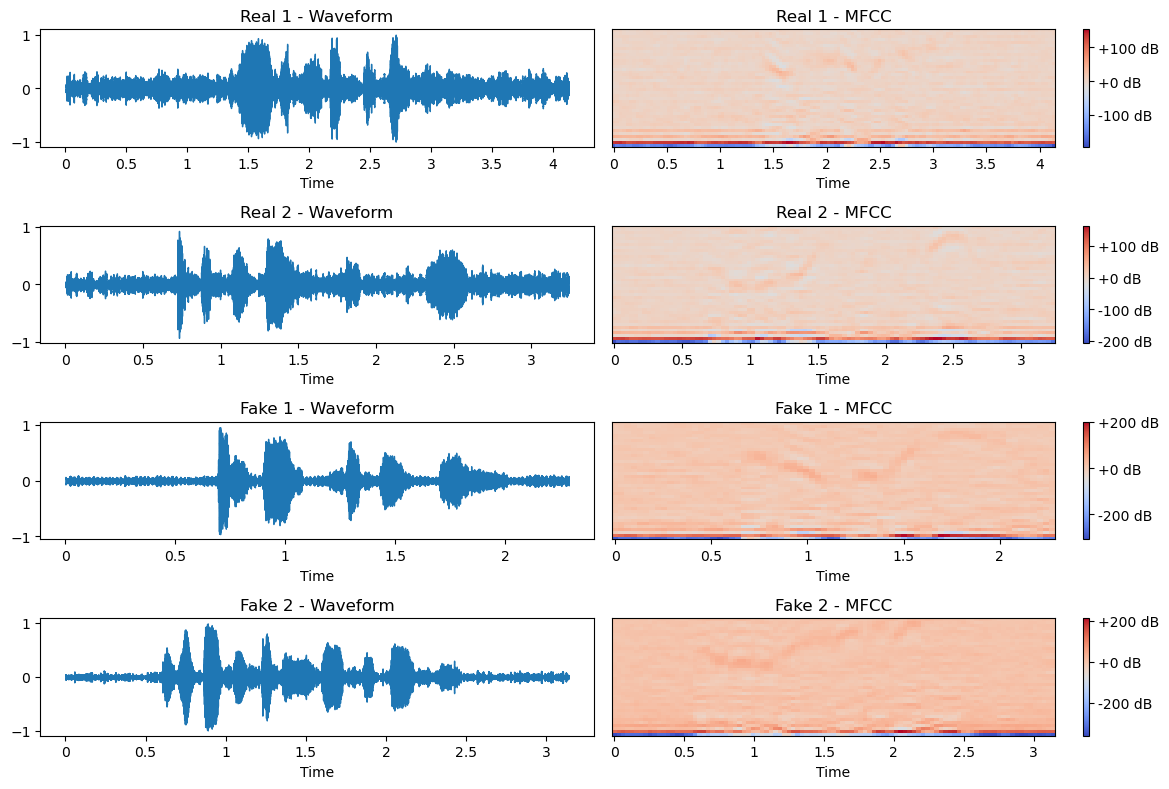

In [11]:
plot_wave_and_mfcc(sample_files, sample_titles, n_mfcc=40)

In [12]:
def plot_class_distribution(y, title):
    counts = Counter(y)
    labels = sorted(counts.keys())
    values = [counts[l] for l in labels]
    names = ["real" if l == 0 else "fake" for l in labels]
    
    plt.figure(figsize=(4,4))
    plt.bar(names, values)
    plt.title(title)
    plt.xlabel("Class")
    plt.ylabel("Count")
    for i, v in enumerate(values):
        plt.text(i, v, str(v), ha='center', va='bottom')
    plt.show()

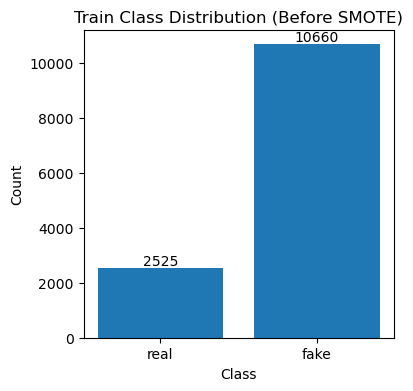

In [13]:
plot_class_distribution(y_train, "Train Class Distribution (Before SMOTE)")

In [14]:
# SMOTE on training data
print("Before SMOTE:", Counter(y_train))

Before SMOTE: Counter({1: 10660, 0: 2525})


In [15]:
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

C:\Users\sruja\anaconda3\envs\tf_base\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


In [16]:
print("After SMOTE:", Counter(y_train_smote))

After SMOTE: Counter({0: 10660, 1: 10660})


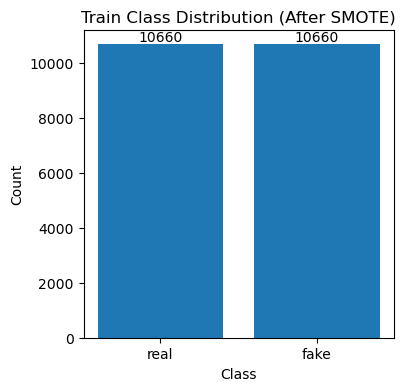

In [17]:
plot_class_distribution(y_train_smote, "Train Class Distribution (After SMOTE)")


In [18]:
# Expand dimension for Conv1D: (n_samples, 40) -> (n_samples, 40, 1)
x_traincnn = np.expand_dims(X_train_smote, axis=2)
x_devcnn   = np.expand_dims(X_dev, axis=2)

In [19]:
print(x_traincnn.shape, x_devcnn.shape)

(21320, 40, 1) (12843, 40, 1)


In [20]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dropout, Flatten, Dense, Activation

In [21]:
num_classes = 2  # real, fake

model = Sequential()
model.add(Conv1D(128, 5, padding='same', input_shape=(40, 1)))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=8))

model.add(Conv1D(128, 5, padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.1))

model.add(Flatten())
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 40, 128)           768       
                                                                 
 activation (Activation)     (None, 40, 128)           0         
                                                                 
 dropout (Dropout)           (None, 40, 128)           0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 5, 128)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 5, 128)            82048     
                                                                 
 activation_1 (Activation)   (None, 5, 128)            0         
                                                        

In [22]:
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)


In [23]:
EPOCHS = 40
BATCH_SIZE = 32

history = model.fit(
    x_traincnn, y_train_smote,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(x_devcnn, y_dev)
)


Epoch 1/40
667/667 [==============================] - 18s 9ms/step - loss: 0.3477 - accuracy: 0.8766 - val_loss: 0.4157 - val_accuracy: 0.8584
Epoch 2/40
667/667 [==============================] - 6s 9ms/step - loss: 0.0957 - accuracy: 0.9644 - val_loss: 0.4308 - val_accuracy: 0.8673
Epoch 3/40
667/667 [==============================] - 6s 10ms/step - loss: 0.0638 - accuracy: 0.9777 - val_loss: 0.4318 - val_accuracy: 0.8551
Epoch 4/40
667/667 [==============================] - 6s 9ms/step - loss: 0.0526 - accuracy: 0.9820 - val_loss: 0.5604 - val_accuracy: 0.8375
Epoch 5/40
667/667 [==============================] - 6s 10ms/step - loss: 0.0489 - accuracy: 0.9831 - val_loss: 0.5177 - val_accuracy: 0.8665
Epoch 6/40
667/667 [==============================] - 6s 9ms/step - loss: 0.0458 - accuracy: 0.9845 - val_loss: 0.6167 - val_accuracy: 0.8707
Epoch 7/40
667/667 [==============================] - 6s 9ms/step - loss: 0.0387 - accuracy: 0.9856 - val_loss: 0.6806 - val_accuracy: 0.8434
Epo

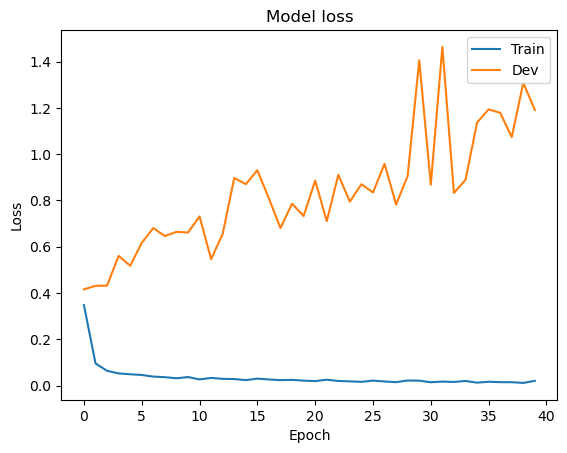

In [24]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Dev'], loc='upper right')
plt.show()


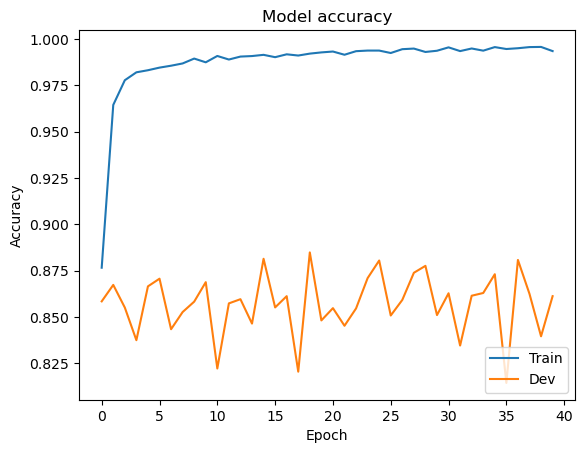

In [25]:
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Dev'], loc='lower right')
plt.show()


In [26]:
# Dev evaluation
dev_loss, dev_acc = model.evaluate(x_devcnn, y_dev, verbose=0)
print(f"Dev accuracy: {dev_acc*100:.2f}%")

Dev accuracy: 86.12%


In [27]:
# Predictions and classification report
y_dev_pred_proba = model.predict(x_devcnn)
y_dev_pred = np.argmax(y_dev_pred_proba, axis=1)

402/402 [==============================] - 1s 2ms/step


In [28]:
print("Classification report (Dev):")
print(classification_report(y_dev, y_dev_pred, target_names=["real", "fake"]))


Classification report (Dev):
              precision    recall  f1-score   support

        real       0.76      0.44      0.56      2548
        fake       0.87      0.97      0.92     10295

    accuracy                           0.86     12843
   macro avg       0.82      0.70      0.74     12843
weighted avg       0.85      0.86      0.85     12843



In [29]:
cm = confusion_matrix(y_dev, y_dev_pred)
print("Confusion matrix (Dev):")
print(cm)

Confusion matrix (Dev):
[[1125 1423]
 [ 359 9936]]


In [32]:
import seaborn as sns
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve, average_precision_score

In [33]:
def plot_confusion_matrix(y_true, y_pred, class_names=["Real", "Fake"]):
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # normalize rows
    
    plt.figure(figsize=(7,5))
    sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    
    plt.title("Confusion Matrix (Normalized)")
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.show()

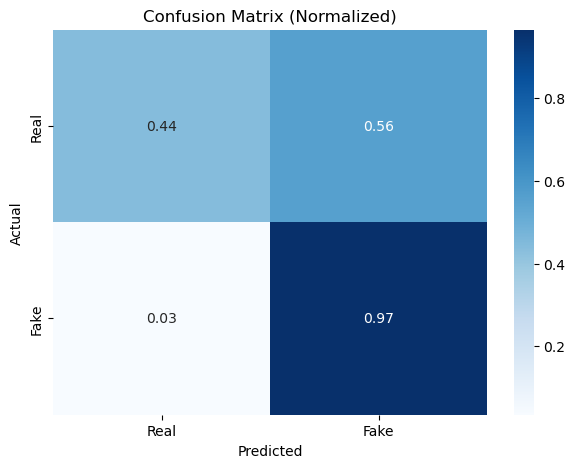

In [34]:
plot_confusion_matrix(y_dev, y_dev_pred)

In [35]:
def plot_accuracy(history):
    plt.figure(figsize=(8,5))
    plt.plot(history.history["accuracy"], label="Train Accuracy")
    plt.plot(history.history["val_accuracy"], label="Dev Accuracy")
    plt.title("Model Accuracy Over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.show()
    
def plot_loss(history):
    plt.figure(figsize=(8,5))
    plt.plot(history.history["loss"], label="Train Loss")
    plt.plot(history.history["val_loss"], label="Dev Loss")
    plt.title("Model Loss Over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.show()
def plot_roc_curve(y_true, y_pred_proba):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba[:,1])
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(7,5))
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
    plt.plot([0,1], [0,1], 'k--')
    plt.title("ROC Curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.grid(True)
    plt.show()
def plot_precision_recall(y_true, y_pred):
    precision, recall, _ = precision_recall_curve(y_true, y_pred[:,1])
    ap = average_precision_score(y_true, y_pred[:,1])
    
    plt.figure(figsize=(7,5))
    plt.plot(recall, precision, label=f"AP = {ap:.2f}")
    plt.title("Precision–Recall Curve")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.legend()
    plt.grid(True)
    plt.show()





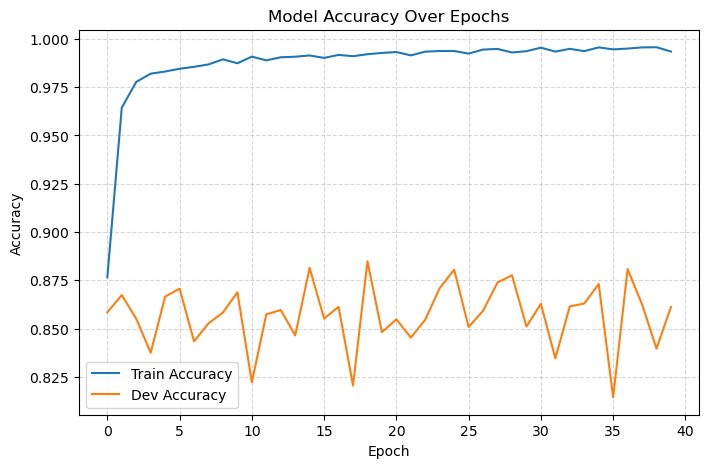

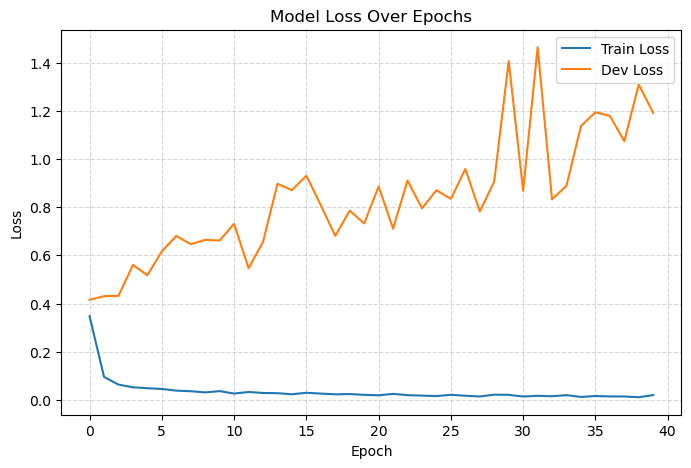

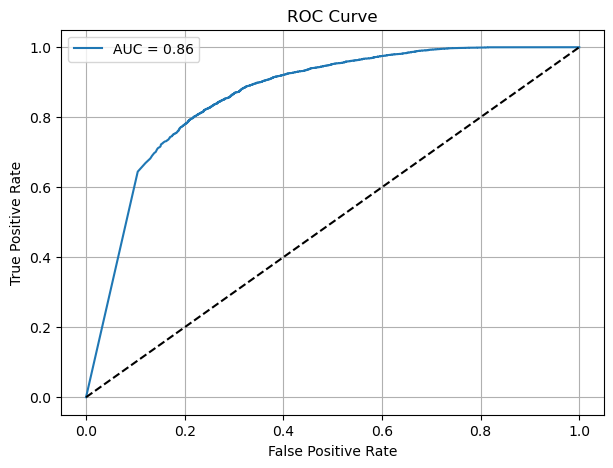

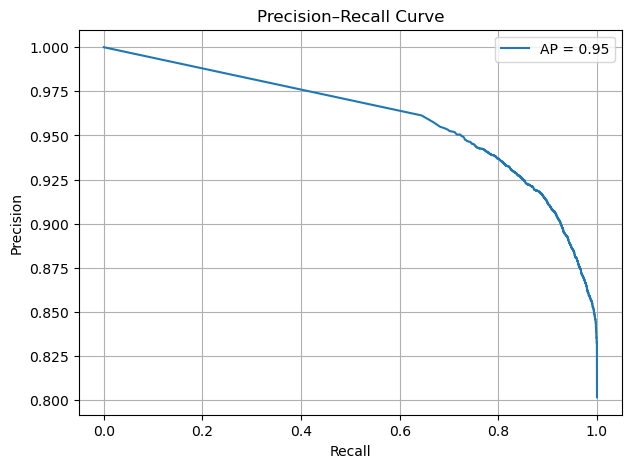

In [36]:
plot_accuracy(history)
plot_loss(history)
plot_roc_curve(y_dev, y_dev_pred_proba)
plot_precision_recall(y_dev, y_dev_pred_proba)

In [37]:
x_evalcnn = np.expand_dims(X_eval, axis=2)
eval_loss, eval_acc = model.evaluate(x_evalcnn, y_eval, verbose=0)

In [38]:
print(f"Eval accuracy: {eval_acc*100:.2f}%")

Eval accuracy: 87.97%


In [39]:
save_dir = os.path.join(BASE_DIR, "saved_models")
os.makedirs(save_dir, exist_ok=True)

model_path = os.path.join(save_dir, "SceneFake_CNN_SMOTE.h5")
model.save(model_path)
print("Saved model to:", model_path)

Saved model to: C:\Users\sruja\Deepfake\deepfake\saved_models\SceneFake_CNN_SMOTE.h5
